In [1]:
import pandas as pd
import numpy as np

In [26]:
def calEnt(dataSet):
    n = dataSet.shape[0]                             #数据集总行数
    iset = dataSet.iloc[:,-1].value_counts()         #标签的所有类别()
    p = iset/n                                       #每一类标签所占比
    ent = (-p*np.log2(p)).sum()                      #计算信息熵
    return ent

In [27]:
def bestSplit(dataSet):
    baseEnt = calEnt(dataSet)                                #计算原始熵
    bestGain = 0                                             #初始化信息增益
    axis = -1                                                #初始化最佳切分列，标签列
    for i in range(dataSet.shape[1]-1):                      #对特征的每一列进行循环(因为最后一列是标签)
        levels= dataSet.iloc[:,i].value_counts().index       #提取出当前列的所有取值
        ents = 0                                             #初始化子节点的信息熵      
        for j in levels:                                     #对当前列的每一个取值进行循环
            childSet = dataSet[dataSet.iloc[:,i]==j]         #某一个子节点的dataframe
            ent = calEnt(childSet)                           #计算某一个子节点的信息熵
            ents += (childSet.shape[0]/dataSet.shape[0])*ent #计算当前列的信息熵t
        #print('第{}列的信息熵为{}'.format(i,ents))
        infoGain = baseEnt-ents                              #计算当前列的信息增益
        #print('第{}列的信息增益为{}'.format(i,infoGain))
        if (infoGain > bestGain):
            bestGain = infoGain                              #选择最大信息增益
            axis = i                                         #最大信息增益所在列的索引
        return axis

In [28]:
def mySplit(dataSet,axis,value):
    col = dataSet.columns[axis]
    redataSet = dataSet.loc[dataSet[col]==value,:].drop(col,axis=1)
    return redataSet

In [29]:
def createTree(dataSet):
    featlist = list(dataSet.columns)                          #提取出数据集所有的列
    classlist = dataSet.iloc[:,-1].value_counts()             #获取最后一列类标签
    #判断最多标签数目是否等于数据集行数，或者数据集是否只有一列
    if classlist[0]==dataSet.shape[0] or dataSet.shape[1] == 1:
        return classlist.index[0]                             #如果是，返回类标签
    axis = bestSplit(dataSet)                                 #确定出当前最佳切分列的索引
    bestfeat = featlist[axis]                                 #获取该索引对应的特征
    myTree = {bestfeat:{}}                                    #采用字典嵌套的方式存储树信息
    del featlist[axis]                                        #删除当前特征
    valuelist = set(dataSet.iloc[:,axis])                     #提取最佳切分列所有属性值
    for value in valuelist:                                   #对每一个属性值递归建树
        myTree[bestfeat][value] = createTree(mySplit(dataSet,axis,value))  #递归createTree里面放的是切分完成之后的数据
    return myTree

In [30]:
def classify(inputTree,labels, testVec):
    firstStr = next(iter(inputTree))                   #获取决策树第一个节点
    secondDict = inputTree[firstStr]                   #下一个字典
    featIndex = labels.index(firstStr)                 #第一个节点所在列的索引
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]) == dict :
                classLabel = classify(secondDict[key], labels, testVec)
            else:
                classLabel = secondDict[key]
    return classLabel

In [31]:
def acc_classify(train,test):
    inputTree = createTree(train)                       #根据测试集生成一棵树
    labels = list(train.columns)                        #数据集所有的列名称
    result = []
    for i in range(test.shape[0]):                      #对测试集中每一条数据进行循环
        testVec = test.iloc[i,:-1]                      #测试集中的一个实例
        classLabel = classify(inputTree,labels,testVec) #预测该实例的分类
        result.append(classLabel)                       #将分类结果追加到result列表中
    test['predict']=result                              #将预测结果追加到测试集最后一列
    acc = (test.iloc[:,-1]==test.iloc[:,-2]).mean()     #计算准确率
    print('模型预测准确率为%f'%acc)
    return test

In [24]:
def getNumLeafs(myTree):
    numleafs = 0
    firstStr = next(iter(myTree))             #获得数的第一个键值
    secondDict = myTree[firstStr]             #获取下一组字典
    for key in secondDict.keys():
        if type(secondDict[key]) == dict:    #测试该节点是否为字典
            numleafs += getNumLeafs(secondDict[key])     #是字典，递归，循环计算新分支叶节点数
        else:
            numleafs += 1                                #不是字典，代表此节点即为叶子节点，0加1即可
    return  numleafs

In [25]:
def getTreeDepth(myTree):
    maxdepth = 0
    firstStr = next(iter(myTree))
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]) == dict :    #测试该节点是否为字典
            thisdepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisdepth = 1
        if thisdepth > maxdepth:
            maxdepth = thisdepth
    return maxdepth 

In [26]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']

In [27]:
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    arrow_args = dict(arrowstyle="<-")											#定义箭头格式
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',	#绘制结点
                            xytext=centerPt, textcoords='axes fraction',
                            va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)

In [28]:
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]											#计算标注位置
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=45)

In [29]:
def plotTree(myTree, parentPt, nodeTxt):
    decisionNode = dict(boxstyle="sawtooth", fc="0.8")										#设置结点格式
    leafNode = dict(boxstyle="round4", fc="0.8")											#设置叶结点格式
    numLeafs = getNumLeafs(myTree)  														#获取决策树叶结点数目，决定了树的宽度
    depth = getTreeDepth(myTree)															#获取决策树层数
    firstStr = next(iter(myTree))															#下个字典
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)	#中心位置
    plotMidText(cntrPt, parentPt, nodeTxt)													#标注有向边属性值
    plotNode(firstStr, cntrPt, parentPt, decisionNode)										#绘制结点
    secondDict = myTree[firstStr]															#下一个字典，也就是继续绘制子结点
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD										#y偏移
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':											#测试该结点是否为字典，如果不是字典，代表此结点为叶子结点
            plotTree(secondDict[key],cntrPt,str(key))        								#不是叶结点，递归调用继续绘制
        else:																				#如果是叶结点，绘制叶结点，并标注有向边属性值
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD

In [30]:
def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')													#创建fig
    fig.clf()																				#清空fig
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)    							#去掉x、y轴
    plotTree.totalW = float(getNumLeafs(inTree))											#获取决策树叶结点数目
    plotTree.totalD = float(getTreeDepth(inTree))											#获取决策树层数
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;								#x偏移
    plotTree(inTree,(0.5,1.0), '')                                                       #绘制决策树
    plt.show()																				#显示绘制结果


In [32]:
# 1、导入数据集

In [32]:
lenses = pd.read_table('lenses.txt',header = None)

In [33]:
lenses

,0,1,2,3,4
0,young,myope,no,reduced,no lenses
1,young,myope,no,normal,soft
2,young,myope,yes,reduced,no lenses
3,young,myope,yes,normal,hard
4,young,hyper,no,reduced,no lenses
5,young,hyper,no,normal,soft
6,young,hyper,yes,reduced,no lenses
7,young,hyper,yes,normal,hard
8,pre,myope,no,reduced,no lenses
9,pre,myope,no,normal,soft


In [34]:
lenses.columns = ['年龄','类型','散光','流眼泪情况','结果']

In [35]:
lenses

,年龄,类型,散光,流眼泪情况,结果
0,young,myope,no,reduced,no lenses
1,young,myope,no,normal,soft
2,young,myope,yes,reduced,no lenses
3,young,myope,yes,normal,hard
4,young,hyper,no,reduced,no lenses
5,young,hyper,no,normal,soft
6,young,hyper,yes,reduced,no lenses
7,young,hyper,yes,normal,hard
8,pre,myope,no,reduced,no lenses
9,pre,myope,no,normal,soft


In [9]:
# 2、划分测试集和数据集

In [83]:
def randsplit(dataset,rand):    #rand是训练集所占得比例，0.8
    l = list(dataset.index)
    np.random.shuffle(l)
    dataset.index = l
    data = dataset.sort_index()
    n = data.shape[0]         #总共多少行数据
    m = int(n * rand)            #切割多少数据
    train = data.iloc[range(m),:]
    test = data.iloc[range(m,n),:]
    #train.index = range(train.shape[0])
    test.index = range(test.shape[0])
    return train,test   

In [84]:
train,test = randsplit(lenses,0.7)

In [85]:
test

,年龄,类型,散光,流眼泪情况,结果
0,pre,myope,yes,normal,hard
1,presbyopic,hyper,yes,normal,no lenses
2,young,myope,yes,reduced,no lenses
3,pre,myope,no,normal,soft
4,pre,hyper,no,normal,soft
5,young,hyper,no,reduced,no lenses
6,pre,hyper,yes,reduced,no lenses
7,presbyopic,hyper,yes,reduced,no lenses


In [86]:
train,test = randsplit(lenses,0.8)

In [87]:
test

,年龄,类型,散光,流眼泪情况,结果
0,young,myope,yes,normal,hard
1,presbyopic,hyper,no,reduced,no lenses
2,presbyopic,hyper,yes,normal,no lenses
3,presbyopic,myope,yes,reduced,no lenses
4,presbyopic,myope,no,reduced,no lenses


In [88]:
# 3、生成决策树并构造

In [89]:
#利用生成的训练集生成决策树
lensesTree = createTree(train)
lensesTree

{'年龄': {'pre': {'类型': {'hyper': {'散光': {'no': {'流眼泪情况': {'normal': 'soft',
        'reduced': 'no lenses'}},
      'yes': 'no lenses'}},
    'myope': {'散光': {'no': {'流眼泪情况': {'normal': 'soft',
        'reduced': 'no lenses'}},
      'yes': {'流眼泪情况': {'normal': 'hard', 'reduced': 'no lenses'}}}}}},
  'presbyopic': {'类型': {'hyper': {'散光': {'no': 'soft', 'yes': 'no lenses'}},
    'myope': {'散光': {'no': 'no lenses', 'yes': 'hard'}}}},
  'young': {'类型': {'hyper': {'散光': {'no': {'流眼泪情况': {'normal': 'soft',
        'reduced': 'no lenses'}},
      'yes': {'流眼泪情况': {'normal': 'hard', 'reduced': 'no lenses'}}}},
    'myope': {'散光': {'no': {'流眼泪情况': {'normal': 'soft',
        'reduced': 'no lenses'}},
      'yes': 'no lenses'}}}}}}

In [90]:
acc_classify(train,test)

模型预测准确率为0.400000


,年龄,类型,散光,流眼泪情况,结果,predict
0,young,myope,yes,normal,hard,no lenses
1,presbyopic,hyper,no,reduced,no lenses,soft
2,presbyopic,hyper,yes,normal,no lenses,no lenses
3,presbyopic,myope,yes,reduced,no lenses,hard
4,presbyopic,myope,no,reduced,no lenses,no lenses


In [91]:
#构造决策树
createPlot(lensesTree)

NameError: name 'createPlot' is not defined

In [102]:
#导入相应的包
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz

In [103]:
dataSet = train
#特征
Xtrain = dataSet.iloc[:,:-1]
for i in Xtrain.columns:
    labels = Xtrain[i].unique().tolist()
    Xtrain[i] = Xtrain[i].apply(lambda x: labels.index(x))
#标签
Ytrain = dataSet.iloc[:,-1]
labels = Ytrain.unique().tolist()
Ytrain = Ytrain.apply(lambda x: labels.index(x))  #将本文转换为数字

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [99]:
dataSet = train
Xtrain = dataSet.iloc[:,:-1]
Xtrain['年龄'].unique().tolist()


['young', 'pre', 'presbyopic']

In [104]:
dataSet = test
#特征
Xtest = dataSet.iloc[:,:-1]
for i in Xtest.columns:
    labels = Xtest[i].unique().tolist()
    Xtest[i] = Xtest[i].apply(lambda x: labels.index(x))
#标签
Ytest = dataSet.iloc[:,-1]
labels = Ytest.unique().tolist()
Ytest = Ytest.apply(lambda x: labels.index(x))  #将本文转换为数字

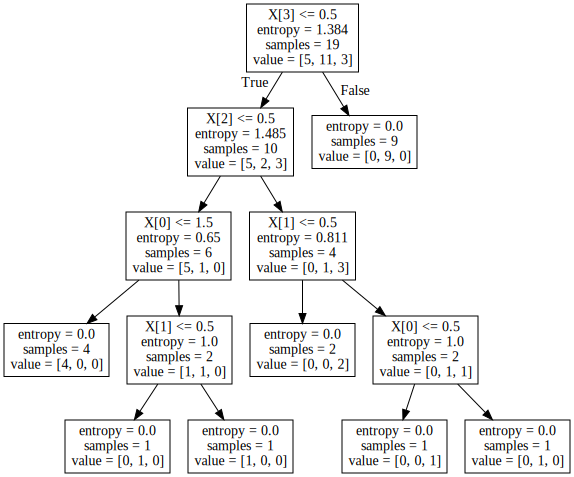

In [105]:
#绘制树模型
clf = DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(Xtrain, Ytrain)
#score = clf.score(Xtest,Ytest)
tree.export_graphviz(clf)
dot_data = tree.export_graphviz(clf, out_file=None)
graphviz.Source(dot_data)


In [24]:
score

0.40000000000000002

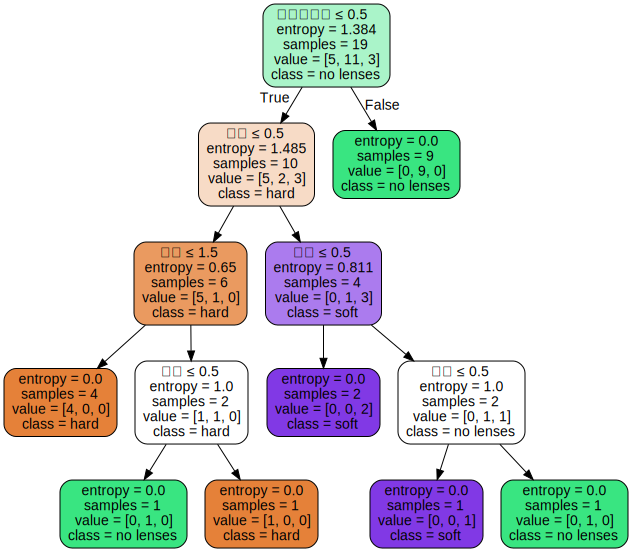

In [106]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
#给图形增加标签和颜色
dot_data = tree.export_graphviz(clf, out_file=None,
                               feature_names=['年龄', '类型','散光','流眼泪情况'],
                               class_names=['hard', 'no lenses','soft'],
                               filled=True, rounded=True,
                               special_characters=True)
graphviz.Source(dot_data)

In [20]:
#利用render方法生成图形
graph = graphviz.Source(dot_data)
graph.render("lenses")

'lenses.pdf'